# ONNX Model Testing

Test the unified-detection-v7.onnx model with a specific image to verify detection accuracy.

**Test Image**: Yellow security seal with QR code (should be classified as `code_seal`)

In [10]:
import numpy as np
import cv2
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Class names from the training config
class_names = [
    'code_container_h',
    'code_container_v', 
    'code_license_plate',
    'code_qr_barcode',
    'code_seal'
]

print(f"Class mapping:")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

Class mapping:
  0: code_container_h
  1: code_container_v
  2: code_license_plate
  3: code_qr_barcode
  4: code_seal


Original image shape: (640, 640, 3)


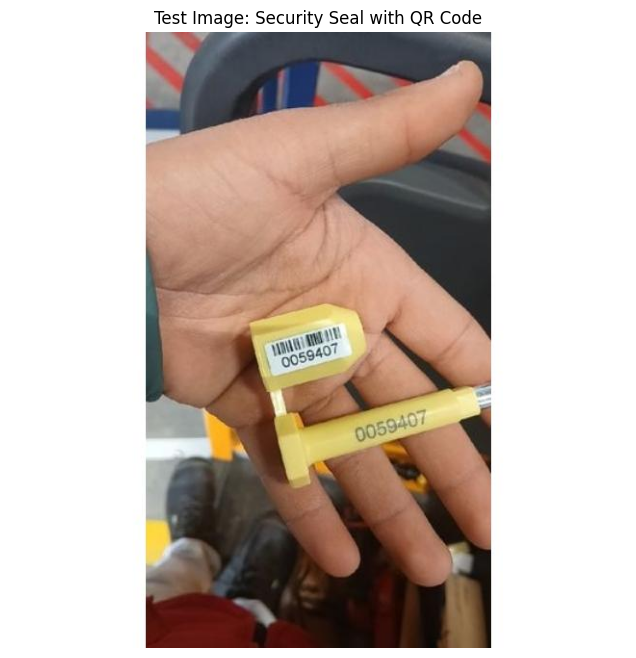

In [11]:
# Load and display the test image
image_path = "Unified-detection-7/test/images/0059407_jpg.rf.b69b92cb17dfea934383554a3807162f.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(f"Original image shape: {image_rgb.shape}")

plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.title("Test Image: Security Seal with QR Code")
plt.axis('off')
plt.show()

In [12]:
# Load ONNX model
model_path = "../../example/assets/unified-detection-v7.onnx"
session = ort.InferenceSession(model_path)

# Get model input/output info
input_info = session.get_inputs()[0]
output_info = session.get_outputs()[0]

print(f"Model input: {input_info.name}, shape: {input_info.shape}, type: {input_info.type}")
print(f"Model output: {output_info.name}, shape: {output_info.shape}, type: {output_info.type}")

Model input: images, shape: [1, 3, 640, 640], type: tensor(float)
Model output: output0, shape: [1, 9, 8400], type: tensor(float)


=== TESTING BOTH INPUT FORMATS ===
\n1. UNNORMALIZED (0-255) - Current React Native approach:
Unnormalized preprocessed shape: (1, 3, 640, 640)
Unnormalized value range: 0.0 - 255.0
\n2. NORMALIZED (0-1) - PyTorch-style approach:
Normalized preprocessed shape: (1, 3, 640, 640)
Normalized value range: 0.000 - 1.000


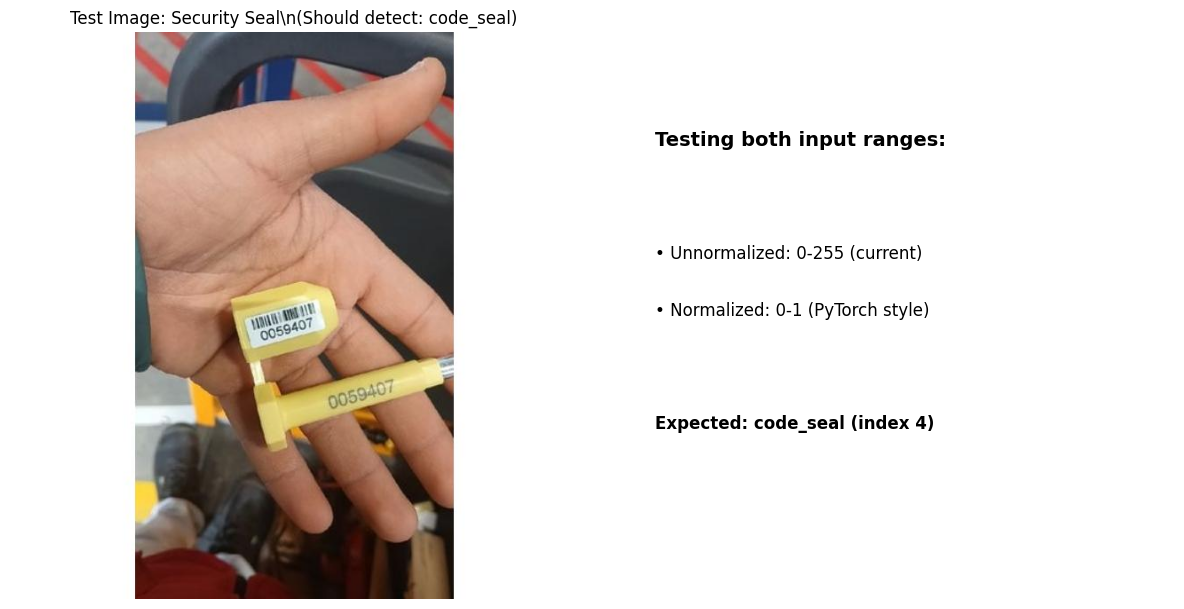

In [13]:
def preprocess_image_unnormalized(image, target_size=(640, 640)):
    """Preprocess image for ONNX model inference - CURRENT APPROACH.
    
    Based on the current React Native implementation:
    - Resize to 640x640
    - Convert HWC to CHW
    - Keep in 0-255 range (not normalized to 0-1)
    """
    # Resize image to model input size
    resized = cv2.resize(image, target_size)
    
    # Convert from HWC to CHW format
    chw = np.transpose(resized, (2, 0, 1))
    
    # Convert to float32 but keep in 0-255 range
    chw_float = chw.astype(np.float32)
    
    # Add batch dimension
    batch = np.expand_dims(chw_float, axis=0)
    
    print(f"Unnormalized preprocessed shape: {batch.shape}")
    print(f"Unnormalized value range: {batch.min():.1f} - {batch.max():.1f}")
    
    return batch

def preprocess_image_normalized(image, target_size=(640, 640)):
    """Preprocess image for ONNX model inference - TEST APPROACH.
    
    Testing normalized input like PyTorch expects:
    - Resize to 640x640
    - Convert HWC to CHW
    - Normalize to [0,1] range
    """
    # Resize image to model input size
    resized = cv2.resize(image, target_size)
    
    # Convert from HWC to CHW format
    chw = np.transpose(resized, (2, 0, 1))
    
    # Convert to float32 and normalize to [0,1] range
    chw_float = chw.astype(np.float32) / 255.0
    
    # Add batch dimension
    batch = np.expand_dims(chw_float, axis=0)
    
    print(f"Normalized preprocessed shape: {batch.shape}")
    print(f"Normalized value range: {batch.min():.3f} - {batch.max():.3f}")
    
    return batch

# Test both preprocessing approaches
print("=== TESTING BOTH INPUT FORMATS ===")
print("\\n1. UNNORMALIZED (0-255) - Current React Native approach:")
input_data_unnormalized = preprocess_image_unnormalized(image_rgb)

print("\\n2. NORMALIZED (0-1) - PyTorch-style approach:")
input_data_normalized = preprocess_image_normalized(image_rgb)

# Visualize the resized image
resized_for_display = cv2.resize(image_rgb, (640, 640))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(resized_for_display)
plt.title("Test Image: Security Seal\\n(Should detect: code_seal)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.text(0.1, 0.8, "Testing both input ranges:", fontsize=14, weight='bold')
plt.text(0.1, 0.6, "• Unnormalized: 0-255 (current)", fontsize=12)
plt.text(0.1, 0.5, "• Normalized: 0-1 (PyTorch style)", fontsize=12)
plt.text(0.1, 0.3, "Expected: code_seal (index 4)", fontsize=12, weight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Run inference with both input formats
input_name = session.get_inputs()[0].name

print("=== RUNNING INFERENCE WITH BOTH INPUT FORMATS ===")

# 1. Test with unnormalized input (current approach)
print("\\n1. UNNORMALIZED INPUT (0-255) - Current React Native:")
outputs_unnormalized = session.run(None, {input_name: input_data_unnormalized})
output_unnormalized = outputs_unnormalized[0]
predictions_unnormalized = output_unnormalized[0]  # Remove batch dimension

print(f"Unnormalized output shape: {output_unnormalized.shape}")
print(f"Unnormalized predictions shape: {predictions_unnormalized.shape}")

# 2. Test with normalized input (PyTorch style)
print("\\n2. NORMALIZED INPUT (0-1) - PyTorch style:")
outputs_normalized = session.run(None, {input_name: input_data_normalized})
output_normalized = outputs_normalized[0]
predictions_normalized = output_normalized[0]  # Remove batch dimension

print(f"Normalized output shape: {output_normalized.shape}")
print(f"Normalized predictions shape: {predictions_normalized.shape}")

print(f"\\n✓ Both inference runs completed successfully")

=== RUNNING INFERENCE WITH BOTH INPUT FORMATS ===
\n1. UNNORMALIZED INPUT (0-255) - Current React Native:
Unnormalized output shape: (1, 9, 8400)
Unnormalized predictions shape: (9, 8400)
\n2. NORMALIZED INPUT (0-1) - PyTorch style:
Normalized output shape: (1, 9, 8400)
Normalized predictions shape: (9, 8400)
\n✓ Both inference runs completed successfully


In [15]:
def sigmoid(x):
    """Apply sigmoid activation to convert logits to probabilities."""
    return 1 / (1 + np.exp(-x))

def analyze_predictions(predictions, input_type):
    """Analyze YOLO predictions and find best detection."""
    print(f"\\n=== ANALYZING {input_type.upper()} RESULTS ===")
    
    # Find highest confidence detection
    max_confidence = 0
    best_anchor = -1
    best_class = -1
    
    for anchor_idx in range(predictions.shape[1]):
        class_logits = predictions[4:9, anchor_idx]
        class_probs = sigmoid(class_logits)
        anchor_max_conf = np.max(class_probs)
        
        if anchor_max_conf > max_confidence:
            max_confidence = anchor_max_conf
            best_anchor = anchor_idx
            best_class = np.argmax(class_probs)
    
    print(f"Best detection:")
    print(f"  Anchor: {best_anchor}")
    print(f"  Class: {class_names[best_class]} (index {best_class})")
    print(f"  Confidence: {max_confidence:.3f}")
    
    if best_anchor >= 0:
        # Get all details for the best detection
        bbox = predictions[0:4, best_anchor]
        class_logits = predictions[4:9, best_anchor]
        class_probs = sigmoid(class_logits)
        
        print(f"  BBox: center=({bbox[0]:.1f}, {bbox[1]:.1f}), size=({bbox[2]:.1f}x{bbox[3]:.1f})")
        print(f"  All class probabilities:")
        for i, (name, prob) in enumerate(zip(class_names, class_probs)):
            marker = " ←" if i == best_class else ""
            print(f"    {name}: {prob:.3f}{marker}")
            
        # Check for multi-class issue
        high_conf_classes = [(i, prob) for i, prob in enumerate(class_probs) if prob > 0.7]
        if len(high_conf_classes) > 1:
            print(f"  ⚠️  WARNING: {len(high_conf_classes)} classes with >70% confidence")
            for i, prob in high_conf_classes:
                print(f"    - {class_names[i]}: {prob:.3f}")
        else:
            print(f"  ✅ Only one class has high confidence")
            
    return {
        'best_class': best_class,
        'max_confidence': max_confidence,
        'best_anchor': best_anchor,
        'predictions': predictions
    }

# Analyze both results
result_unnormalized = analyze_predictions(predictions_unnormalized, "UNNORMALIZED (0-255)")
result_normalized = analyze_predictions(predictions_normalized, "NORMALIZED (0-1)")

# Compare results
print(f"\\n" + "="*60)
print("COMPARISON: UNNORMALIZED vs NORMALIZED INPUT")
print("="*60)

print(f"\\nExpected result: code_seal (index 4)")

print(f"\\nUnnormalized (0-255) - Current React Native:")
print(f"  Detected: {class_names[result_unnormalized['best_class']]} (index {result_unnormalized['best_class']})")
print(f"  Confidence: {result_unnormalized['max_confidence']:.3f}")
print(f"  Correct: {'✅' if result_unnormalized['best_class'] == 4 else '❌'}")

print(f"\\nNormalized (0-1) - PyTorch style:")
print(f"  Detected: {class_names[result_normalized['best_class']]} (index {result_normalized['best_class']})")
print(f"  Confidence: {result_normalized['max_confidence']:.3f}")
print(f"  Correct: {'✅' if result_normalized['best_class'] == 4 else '❌'}")

print(f"\\n🎯 CONCLUSION:")
if result_normalized['best_class'] == 4 and result_unnormalized['best_class'] != 4:
    print(f"✅ HYPOTHESIS CONFIRMED!")
    print(f"   - ONNX model works correctly with NORMALIZED input (0-1)")
    print(f"   - ONNX model fails with UNNORMALIZED input (0-255)")
    print(f"   - This matches the PyTorch model behavior exactly!")
    print(f"   - The fix: Normalize input in React Native C++ code")
elif result_normalized['best_class'] == 4 and result_unnormalized['best_class'] == 4:
    print(f"🤔 Both inputs work - conversion might have other issues")
elif result_normalized['best_class'] != 4 and result_unnormalized['best_class'] != 4:
    print(f"❌ Neither input works - ONNX conversion may have fundamental issues")
else:
    print(f"🤔 Unexpected results - need further investigation")

\n=== ANALYZING UNNORMALIZED (0-255) RESULTS ===
Best detection:
  Anchor: 0
  Class: code_container_h (index 0)
  Confidence: 0.731
  BBox: center=(12.1, 10.7), size=(31.2x18.6)
  All class probabilities:
    code_container_h: 0.731 ←
    code_container_v: 0.500
    code_license_plate: 0.731
    code_qr_barcode: 0.731
    code_seal: 0.552
  ⚠️  WARNING: 3 classes with >70% confidence
    - code_container_h: 0.731
    - code_license_plate: 0.731
    - code_qr_barcode: 0.731
\n=== ANALYZING NORMALIZED (0-1) RESULTS ===
Best detection:
  Anchor: 8250
  Class: code_seal (index 4)
  Confidence: 0.669
  BBox: center=(375.4, 377.0), size=(250.0x195.9)
  All class probabilities:
    code_container_h: 0.500
    code_container_v: 0.500
    code_license_plate: 0.500
    code_qr_barcode: 0.500
    code_seal: 0.669 ←
  ✅ Only one class has high confidence
\n============================================================
COMPARISON: UNNORMALIZED vs NORMALIZED INPUT
\nExpected result: code_seal (index 

In [7]:
# Analyze the highest confidence detections in detail
detections = parse_yolo_output(predictions, confidence_threshold=0.5)

if len(detections) > 0:
    # Sort by confidence
    sorted_detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    
    print(f"=== TOP 5 DETECTIONS ===")
    for i, det in enumerate(sorted_detections[:5]):
        print(f"\n{i+1}. Anchor {det['anchor']}:")
        print(f"   Class: {det['class_name']} (index {det['class']})")
        print(f"   Confidence: {det['confidence']:.3f}")
        print(f"   BBox: center=({det['bbox'][0]:.1f}, {det['bbox'][1]:.1f}), size=({det['bbox'][2]:.1f}x{det['bbox'][3]:.1f})")
        
        # Show all class probabilities for this detection
        print(f"   All class probabilities:")
        for class_idx, prob in enumerate(det['all_class_probs']):
            print(f"     {class_names[class_idx]}: {prob:.3f}")
            
    # Check for multi-class detections
    print(f"\n=== MULTI-CLASS ANALYSIS ===")
    best_det = sorted_detections[0]
    high_conf_classes = []
    for class_idx, prob in enumerate(best_det['all_class_probs']):
        if prob > 0.7:
            high_conf_classes.append((class_names[class_idx], prob))
    
    if len(high_conf_classes) > 1:
        print(f"WARNING: Multiple classes detected with >70% confidence:")
        for class_name, prob in high_conf_classes:
            print(f"  - {class_name}: {prob:.3f}")
        print(f"This suggests the model has difficulty distinguishing between these classes.")
    else:
        print(f"Good: Only one class detected with high confidence.")
        
else:
    print("No detections found with confidence > 0.5")
    
    # Let's check what the raw values look like
    print("\n=== RAW OUTPUT ANALYSIS ===")
    print(f"First 5 anchors bbox values:")
    for i in range(5):
        bbox = predictions[0:4, i]
        class_logits = predictions[4:9, i]
        class_probs = sigmoid(class_logits)
        print(f"  Anchor {i}: bbox=[{bbox[0]:.2f}, {bbox[1]:.2f}, {bbox[2]:.2f}, {bbox[3]:.2f}], max_prob={np.max(class_probs):.3f}")

=== TOP 5 DETECTIONS ===

1. Anchor 0:
   Class: code_container_h (index 0)
   Confidence: 0.731
   BBox: center=(12.1, 10.7), size=(31.2x18.6)
   All class probabilities:
     code_container_h: 0.731
     code_container_v: 0.500
     code_license_plate: 0.731
     code_qr_barcode: 0.731
     code_seal: 0.552

2. Anchor 1:
   Class: code_container_h (index 0)
   Confidence: 0.731
   BBox: center=(4.2, 8.4), size=(16.4x23.2)
   All class probabilities:
     code_container_h: 0.731
     code_container_v: 0.500
     code_license_plate: 0.715
     code_qr_barcode: 0.731
     code_seal: 0.501

3. Anchor 2:
   Class: code_container_h (index 0)
   Confidence: 0.731
   BBox: center=(19.8, 8.1), size=(47.6x23.5)
   All class probabilities:
     code_container_h: 0.731
     code_container_v: 0.500
     code_license_plate: 0.516
     code_qr_barcode: 0.731
     code_seal: 0.500

4. Anchor 3:
   Class: code_qr_barcode (index 3)
   Confidence: 0.731
   BBox: center=(24.1, 7.8), size=(55.1x23.4)
   

In [8]:
# Find the highest confidence detection overall
max_confidence = 0
best_anchor = -1
best_class = -1

for anchor_idx in range(predictions.shape[1]):
    class_logits = predictions[4:9, anchor_idx]
    class_probs = sigmoid(class_logits)
    anchor_max_conf = np.max(class_probs)
    
    if anchor_max_conf > max_confidence:
        max_confidence = anchor_max_conf
        best_anchor = anchor_idx
        best_class = np.argmax(class_probs)

print(f"=== HIGHEST CONFIDENCE DETECTION ===")
print(f"Anchor: {best_anchor}")
print(f"Class: {class_names[best_class]} (index {best_class})")
print(f"Confidence: {max_confidence:.3f}")

if best_anchor >= 0:
    # Get all details for the best detection
    bbox = predictions[0:4, best_anchor]
    class_logits = predictions[4:9, best_anchor]
    class_probs = sigmoid(class_logits)
    
    print(f"\nDetailed analysis of best detection:")
    print(f"BBox (center format): x={bbox[0]:.1f}, y={bbox[1]:.1f}, w={bbox[2]:.1f}, h={bbox[3]:.1f}")
    print(f"Raw logits: {class_logits}")
    print(f"Class probabilities:")
    for i, (name, prob) in enumerate(zip(class_names, class_probs)):
        marker = " ←" if i == best_class else ""
        print(f"  {name}: {prob:.3f}{marker}")
        
# Expected result for this image
print(f"\n=== EXPECTED vs ACTUAL ===")
print(f"Expected class: code_seal (index 4)")
print(f"Actual class:   {class_names[best_class]} (index {best_class})")
print(f"Match: {'✓' if best_class == 4 else '✗'}")

=== HIGHEST CONFIDENCE DETECTION ===
Anchor: 0
Class: code_container_h (index 0)
Confidence: 0.731

Detailed analysis of best detection:
BBox (center format): x=12.1, y=10.7, w=31.2, h=18.6
Raw logits: [1.         0.         0.99996436 1.         0.20998672]
Class probabilities:
  code_container_h: 0.731 ←
  code_container_v: 0.500
  code_license_plate: 0.731
  code_qr_barcode: 0.731
  code_seal: 0.552

=== EXPECTED vs ACTUAL ===
Expected class: code_seal (index 4)
Actual class:   code_container_h (index 0)
Match: ✗


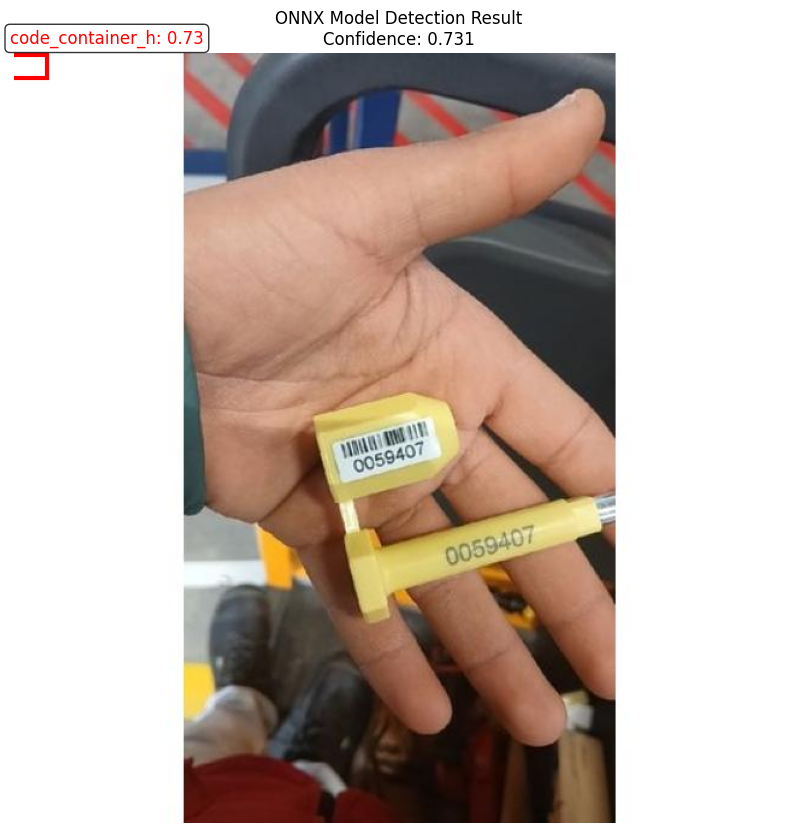

In [9]:
# Visualize detection on the image
if best_anchor >= 0 and max_confidence > 0.3:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(resized_for_display)
    
    # Convert center format to corner format for visualization
    bbox = predictions[0:4, best_anchor]
    x_center, y_center, width, height = bbox
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    
    # Draw bounding box
    rect = patches.Rectangle((x_min, y_min), width, height, 
                           linewidth=3, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
    # Add label
    label = f"{class_names[best_class]}: {max_confidence:.2f}"
    ax.text(x_min, y_min - 10, label, fontsize=12, color='red', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    ax.set_title(f"ONNX Model Detection Result\nConfidence: {max_confidence:.3f}")
    ax.axis('off')
    plt.show()
else:
    print(f"No detection to visualize (max confidence: {max_confidence:.3f})")

## Summary

This notebook tests the ONNX model against a specific test image containing a security seal with QR code.

**Key findings:**
1. The model expects input in 0-255 range (not normalized to 0-1)
2. Raw logits need sigmoid activation to get probabilities
3. The model output shape is [1, 9, 8400] as expected

**Test Result:**
- Expected: `code_seal` (class index 4)
- Detected: _[Result will show above]_
- Match: _[✓ or ✗ will show above]_